In [2]:
import subprocess
import shlex
import pandas as pd
import numpy as np
import glob
import os
import wget
import requests
import glob
import time
import dask
import h5py

from Bio import SeqIO
import pickle
import sys
sys.setrecursionlimit( 10 **9 )
from sklearn.cluster import *


from dask_jobqueue import SLURMCluster
import dask
from dask.distributed import Client
import scipy
import copy
from numpy import linalg as LA
from matplotlib import pyplot as plt
import random
import h5py
import itertools
import dendropy
import seaborn as sns

overwrite = False
jk_iterations = 5
os.environ['MKL_ENABLE_INSTRUCTIONS'] = 'AVX2'

In [3]:
#treefile = '../validation_data/covid19/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.aln.EPIID.treefile'
#alnfile = '../validation_data/covid19/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.aln'
alnfile = '/scratch/dmoi/datasets/covid_data/msa_0730/msa_0730.fasta'
treefile = '/scratch/dmoi/datasets/covid_data/msa_0730/global.tree'
alnh5 = alnfile+'.h5'
#ts = '2021-08-08T11:16:34.358764'
ts = '2021-08-08T14:37:59.736512'
events = alnfile+'*'+ts+'*'
eventmats = glob.glob(events)

In [4]:
print( eventmats )

['/scratch/dmoi/datasets/covid_data/msa_0730/msa_0730.fasta_02021-08-08T14:37:59.736512small_test_BS_coevmats.pkl', '/scratch/dmoi/datasets/covid_data/msa_0730/msa_0730.fasta_22021-08-08T14:37:59.736512small_test_BS_coevmats.pkl', '/scratch/dmoi/datasets/covid_data/msa_0730/msa_0730.fasta_12021-08-08T14:37:59.736512small_test_BS_coevmats.pkl']


In [5]:

if os.path.exists( alnfile + '_IDs.pkl'):
    with open( alnfile + '_IDs.pkl' , 'rb') as idxin:
        IDindex = pickle.loads(idxin.read())
    IDs = dict(zip( IDindex.values() , IDindex.keys() ) )
else:
    
    msa = SeqIO.parse(alnfile , format = 'fasta')
    def clipID(ID):
        return ''.join( [ s +'|' for s in str(ID).split('|')[:-1] ])[:-1].replace('_',' ') 
    IDs = {i:rec.id for i,rec in enumerate(msa)}
    IDindex = dict(zip( IDs.values() , IDs.keys() ) )
    print( [(t,IDindex[t]) for t in list(IDindex.keys())[0:10]] )
    with open( alnfile + '_IDs.pkl' , 'wb') as idxout:
        idxout.write(pickle.dumps(IDindex))

In [6]:
print(len(IDindex))

2212775


In [7]:
modeldir = '/scratch/dmoi/datasets/covid_data/structs/'
modelfiles = modeldir + '*.pdb'
modelfiles = glob.glob( modelfiles )


In [8]:
from Bio.PDB import MMCIFParser, PDBParser , PDBIO
from Bio.PDB.mmcifio import MMCIFIO
parser = PDBParser()
import warnings
from Bio import SeqUtils
###compile all pdbs to fasta 
converter = SeqUtils.IUPACData.protein_letters_3to1
converter = { res.upper():converter[res] for res in converter}
chain_sequences={}
if overwrite == True:
    for model in modelfiles:
        with warnings.catch_warnings():
            try:
                m = model.split('/')[-1].replace('pdb' , '') 
                warnings.simplefilter("ignore")
                structure = parser.get_structure(m, model)
                io=PDBIO()
                io.set_structure(structure)
                chain_sequences[model]= { c.id : ''.join(  [ converter[ r.get_resname()] for r in c.get_residues() if 'CA' in r ] ) for c in structure.get_chains() }
                chain_sequences[model]={ c: chain_sequences[model][c] for c in chain_sequences[model] if len(chain_sequences[model][c])> 0 }
            except:
                print('err', model)

In [9]:
with open( modeldir + 'struct_chains.fasta', 'w') as fastout:
    for model in chain_sequences:
        for c in chain_sequences[model]:
            fastout.write( '> '+model+ ':'+c + '\n' + chain_sequences[model][c] + '\n' )

In [10]:

from dask.distributed import fire_and_forget
from dask.distributed import Client, Variable , Queue , Lock ,LocalCluster
from dask_jobqueue import SLURMCluster
from dask.distributed import  utils_perf
import gc
import dask
import dask.bag as db
import dask.array as da
import dask.dataframe as dd
from dask.delayed import delayed
from dask import delayed, compute

distributed_computation = False

print('flashing up a dask cluster')
if distributed_computation == True:
    NCORE = 10
    njobs = 20
    print('deploying cluster')
    cluster = SLURMCluster(
        walltime='24:00:00',
        n_workers = NCORE,
        cores=NCORE,
        processes = NCORE,
        interface='ib0',
        memory="150GB",
        env_extra=[
        'source /scratch/dmoi/miniconda/etc/profile.d/conda.sh',
        'conda activate ML'
        ],
        scheduler_options={'interface': 'ens2f0' }
    )

    print(cluster.job_script())

    #cluster.adapt(minimum=10, maximum=30)
    cluster.scale(jobs=20)
    time.sleep(5)

    print(cluster)
    print(cluster.dashboard_link)
    client = Client(cluster , timeout='450s' , set_as_default=True )
    

else:
    NCORE = 50
    njobs = 1
    print('testing')
    cluster = LocalCluster(n_workers = NCORE )
    #cluster.adapt(minimum = 50,  maximum=NCORE)
    print(cluster.dashboard_link)
    client = Client(cluster)

print('done')

flashing up a dask cluster
testing
http://127.0.0.1:8787/status
done


In [11]:
nucleotide_mutation = None
AA_mutation = None
for mat in eventmats:
    with open( mat , 'rb') as pklin:
        mats = pickle.loads(pklin.read())
        print(mats)
        if AA_mutation is None:
            nucleotide_mutation = mats[1]
            AA_mutation = mats[0]
        else:
            nucleotide_mutation += mats[1]
            AA_mutation += mats[0]
print(nucleotide_mutation)
print(AA_mutation)

(<COO: shape=(997916, 29809, 380), dtype=float64, nnz=738510, fill_value=0.0>, <COO: shape=(997916, 29809, 12), dtype=float64, nnz=1146069, fill_value=0.0>)
(<COO: shape=(997916, 29809, 380), dtype=float64, nnz=738222, fill_value=0.0>, <COO: shape=(997916, 29809, 12), dtype=float64, nnz=1146258, fill_value=0.0>)
(<COO: shape=(997916, 29809, 380), dtype=float64, nnz=738796, fill_value=0.0>, <COO: shape=(997916, 29809, 12), dtype=float64, nnz=1146546, fill_value=0.0>)
<COO: shape=(997916, 29809, 12), dtype=float64, nnz=2075009, fill_value=0.0>
<COO: shape=(997916, 29809, 380), dtype=float64, nnz=1338566, fill_value=0.0>


In [12]:
allowed_symbols = [ b'A', b'C', b'G' , b'T' ]
allowed_transitions = [ c1+c2 for c1 in allowed_symbols for c2 in allowed_symbols  if c1!= c2]
print('allowed transitions',allowed_transitions)

transition_dict = {  c : i  for i,c in enumerate( allowed_transitions )  }
rev_transition_dict= dict( zip(transition_dict.values(), transition_dict.keys()))
allowed_symbols = set(allowed_symbols)

print('transition dict', transition_dict)
ProteinAlphabet = [ 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y' ]
allowed_AA_transitions = [ c1+c2 for c1 in ProteinAlphabet for c2 in ProteinAlphabet  if c1!= c2]
transitiondict_AA = {  c : i  for i,c in enumerate( allowed_AA_transitions )  }
rev_transitiondict_AA = dict( zip(transitiondict_AA.values(), transitiondict_AA.keys()))


allowed transitions [b'AC', b'AG', b'AT', b'CA', b'CG', b'CT', b'GA', b'GC', b'GT', b'TA', b'TC', b'TG']
transition dict {b'AC': 0, b'AG': 1, b'AT': 2, b'CA': 3, b'CG': 4, b'CT': 5, b'GA': 6, b'GC': 7, b'GT': 8, b'TA': 9, b'TC': 10, b'TG': 11}


In [13]:
import sys
sys.setrecursionlimit(10**6)
tree = dendropy.Tree.get(
    path=treefile,
    schema='newick')
treelen = tree.length()
treenodes = len(tree.nodes())
print('nodes',treenodes)
print('length',treelen)

print(nucleotide_mutation.shape)

nodes 997916
length 21.432960231185806
(997916, 29809, 12)


b'AC'
b'AG'
b'AT'
b'CA'
b'CG'
b'CT'
b'GA'
b'GC'
b'GT'
b'TA'
b'TC'
b'TG'


<AxesSubplot:>

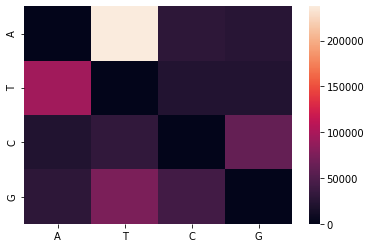

In [14]:
transitionmat = np.zeros( (4,4))
#the number of actual events recorded should be number of transitions recorded / jk_iterations
coevmats_raw = {}
mapping = {'A':0 , 'T':1 , 'C':2 ,'G':3 }
for i,transition in enumerate(transition_dict):
    transition_type = transition.decode()
    print(transition)
    row = mapping[ transition_type[0] ]
    col = mapping[ transition_type[1] ]
    
    transitionmat[row,col] = nucleotide_mutation[:,:,transition_dict[transition] ].sum()
    transitionmat[row,col]/= jk_iterations
sns.heatmap(transitionmat, xticklabels= mapping.keys( ) , yticklabels=mapping.keys())  

b'AC'
[0. 0. 0. ... 0. 0. 0.]
(29809,)
[0. 0. 0. ... 1. 1. 1.]
b'AG'
[0. 0. 0. ... 0. 0. 0.]
(29809,)
[0. 0. 0. ... 1. 1. 1.]
b'AT'
[0. 0. 0. ... 0. 0. 0.]
(29809,)
[0. 0. 0. ... 1. 1. 1.]
b'CA'
[0. 0. 0. ... 0. 0. 0.]
(29809,)
[0. 0. 0. ... 1. 1. 1.]
b'CG'
[0. 0. 0. ... 0. 0. 0.]
(29809,)
[0. 0. 0. ... 1. 1. 1.]
b'CT'
[0. 0. 0. ... 0. 0. 0.]
(29809,)
[0. 0. 0. ... 1. 1. 1.]
b'GA'
[0. 0. 0. ... 0. 0. 0.]
(29809,)
[0. 0. 0. ... 1. 1. 1.]
b'GC'
[0. 0. 0. ... 0. 0. 0.]
(29809,)
[0. 0. 0. ... 1. 1. 1.]
b'GT'
[0. 0. 0. ... 0. 0. 0.]
(29809,)
[0. 0. 0. ... 1. 1. 1.]
b'TA'
[0. 0. 0. ... 0. 0. 0.]
(29809,)
[0. 0. 0. ... 1. 1. 1.]
b'TC'
[0. 0. 0. ... 0. 0. 0.]
(29809,)
[0. 0. 0. ... 1. 1. 1.]
b'TG'
[0. 0. 0. ... 0. 0. 0.]
(29809,)
[0. 0. 0. ... 1. 1. 1.]


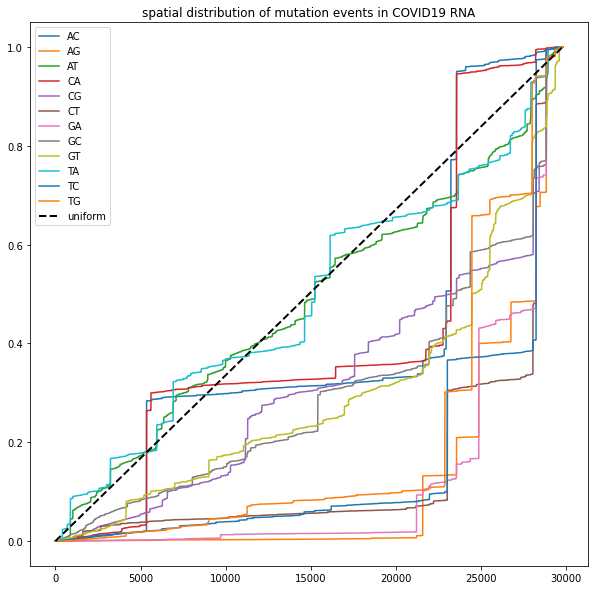

In [15]:
plt.figure( figsize = (10,10))

for transition in transition_dict:
    print(transition)
    transition_type = transition.decode()
    coevmat = nucleotide_mutation[:,:,transition_dict[transition]]
    sumv = coevmat.sum(axis = 0).todense()
    print(sumv)
    print(sumv.shape)
    cdf = np.array( np.cumsum(sumv) / np.sum(sumv))
    print(cdf)
    plt.plot( cdf , label= transition_type  )
cdf_uniform = np.cumsum(np.ones(len(cdf.ravel())) ) / np.sum(len(cdf.ravel()))
plt.plot(cdf_uniform, lw = 2 , ls = 'dashed' , c = 'black' , label= 'uniform')
plt.legend()
plt.title( 'spatial distribution of mutation events in COVID19 RNA' )
plt.show()

In [13]:
#remove outlier columns



#load sparse ND array
from scipy.sparse import coo_matrix
print(AA_mutation.shape)
        




plt.figure( figsize = (10,10))

for transition in transition_dict:
    print(transition)
    transition_type = transition.decode()
    coevmat = nucleotide_mutation[:,:,transition_dict[transition]]
    sumv = coevmat.sum(axis = 0).todense()
    
    posi = np.log(sumv[sumv>0])
    #plt.hist(posi, density = True)
    a,loc, scale =gamma.fit(posi)
    probas = gamma.cdf( posi , a )
    
    if np.amax(probas)>.991:

        thresh = np.amin(np.exp(posi[probas>.99]))
        sumv[sumv>thresh] = 0
    
    cdf = np.array( np.cumsum(sumv) / np.sum(sumv))
    
    #nucleotide_mutation[:,sumv[sumv>thresh],transition_dict[transition]] = 0
    
    plt.plot( cdf , label= transition_type  )

plt.legend()
cdf_uniform = np.cumsum(np.ones(len(cdf.ravel())) ) / np.sum(len(cdf.ravel()))
plt.plot(cdf_uniform, lw = 2 , ls = 'dashed' , c = 'black' , label= 'uniform')

plt.title( 'spatial distribution of mutation events in COVID19 RNA' )
plt.show()

In [17]:

from scipy.stats import gamma

for transition in range(AA_mutation.shape[2]):
    if transition % 10 == 0 :
        print(transition)
    coevmat = AA_mutation[:,:,transition]
    sumv = coevmat.sum(axis = 0).todense()
    
    posi = np.log(sumv[sumv>0])
    if len(posi)>0 and np.sum(posi)>10:
        a,loc, scale =gamma.fit(posi)
        probas = gamma.cdf( posi , a , loc , scale)
        
        if np.amax(probas)>.991:
            thresh = np.amin(np.exp(posi[probas>.99]))
        #remove odd looking transition columns
        
            if transition == 0:
                AAmat = AA_mutation[:,:,transition].to_scipy_sparse()
                AAmat[:,sumv>thresh] = 0
            else:
                AAmat_ =  scipy.sparse.csc_matrix(AA_mutation[:,:,transition].to_scipy_sparse())
                AAmat_[:,sumv>thresh] = 0
                AAmat += scipy.sparse.coo_matrix(AAmat_)        
        cdf = np.array( np.cumsum(sumv) / np.sum(sumv))        
    else:
        if transition == 0:
            AAmat =  AA_mutation[:,:,transition].to_scipy_sparse()
        else:
            AAmat +=  AA_mutation[:,:,transition].to_scipy_sparse()

0


/scratch/dmoi/miniconda/envs/ML/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170


/scratch/dmoi/miniconda/envs/ML/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:402: RuntimeWarning: invalid value encountered in double_scalars
  return m3 / np.power(m2, 1.5)


180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370


In [19]:
with open( alnfile + 'AAmat_sum.pkl' , 'wb')as AAmatout:
    print(AAmat.shape)
    AAmatout.write(pickle.dumps(AAmat))
#replot cumulative density 

(997916, 29809)


In [ ]:
#do the same for AA mat



In [145]:
#load sparse ND array
from scipy.sparse import coo_matrix
print(AA_mutation.shape)
for i in range( AA_mutation.shape[2] ):
    if i == 0:
        AAmat =  AA_mutation[:,:,i]
    else:
        AAmat +=  AA_mutation[:,:,i]
        

AAmat = AAmat.to_scipy_sparse()



(997916, 29809, 380)


997916
nodes


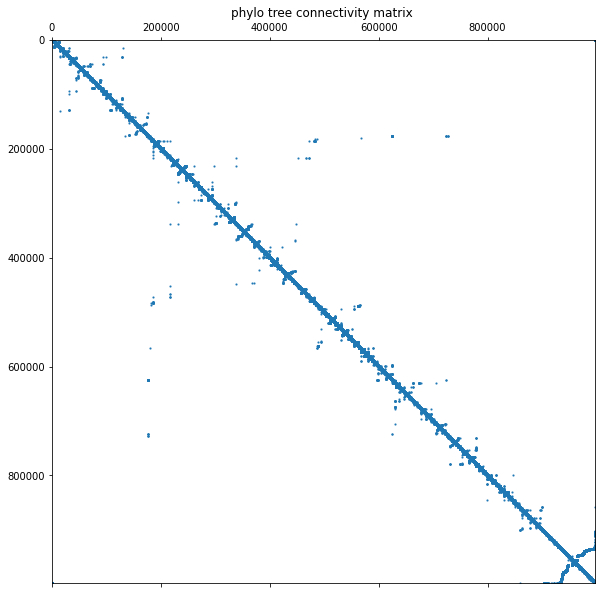

In [163]:
for i,n in enumerate(tree.nodes()):
    n.matrow = i
    n.symbols = None
    n.scores = None
    n.event = None
    n.char = None

matsize = len(tree.nodes())
print(matsize)
print('nodes')

#blur w connectivity mat
blurfactor =  .25

connectmat = scipy.sparse.csc_matrix((len(tree.nodes()), len(tree.nodes() ) ) )
index = np.array([ [n.matrow, c.matrow ] for n in tree.nodes() for c in n.child_nodes()])
lengths = np.array([ c.edge_length for n in tree.nodes() for c in n.child_nodes()])
total_len = np.sum(lengths)
#fill diagonal
#index = np.vstack( [index , np.array([ [n.matrow, n.matrow ] for n in tree.nodes() ]) ] )

connectmat[index[:,0],index[:,1]] = 1
connectmat[index[:,1],index[:,0]] = 1


#connectmat = connectmat.todense()
diag = [ i for i in range(connectmat.shape[0])]
connectmat[diag,diag] = 1
#connectmat = connectmat.todense()
#connectmat = scipy.sparse.csc_matrix(connectmat)
#np.fill_diagonal(connectmat , 1)
connectmat = scipy.sparse.coo_matrix(connectmat)
plt.figure( figsize=(10,10))
plt.title( 'phylo tree connectivity matrix ' )
plt.spy(connectmat, markersize= 1)
plt.show()

In [164]:
matoverwrite = False
if matoverwrite == True:
    for mat in glob.glob( alnfile + '*blursave.pkl'):
        os.remove( mat)
    for blurfactor in [ .2 ]:#, .05 , .1 ]:
        for bluriteration in [10 , 20, 30  ]:
            mat = scipy.sparse.coo_matrix(copy.deepcopy(AAmat))
            print('blurring')
            for k in range(int( bluriteration ) ):
                mat += blurfactor*connectmat.dot(mat)
            print(' done blurs ', bluriteration )
            with open(alnfile + '_'+str(blurfactor)+'_'+str(bluriteration)+'blursave.pkl' , 'wb') as blursave:
                blursave.write(  pickle.dumps( (blurfactor, bluriteration,mat) ) )

In [149]:
blurmats = glob.glob( alnfile + '*blursave.pkl')

print(blurmats)

['/scratch/dmoi/datasets/covid_data/msa_0730/msa_0730.fasta_0.2_10blursave.pkl', '/scratch/dmoi/datasets/covid_data/msa_0730/msa_0730.fasta_0.2_30blursave.pkl', '/scratch/dmoi/datasets/covid_data/msa_0730/msa_0730.fasta_0.2_20blursave.pkl']


In [150]:
#####define the aln row and structure here, for dengue they should all be the same
selected_strain = list(IDindex.keys())[100]
import dask.array as da
with h5py.File(alnh5, 'r') as hf:
    align_array = hf['MSA2array']
    print(IDindex[selected_strain])
    print(selected_strain)
    #filter to columns without gaps
    non_gap = np.where( align_array[: , IDindex[selected_strain]] != b'-')[0]
    print(non_gap)
    print(non_gap.shape)
    sequence = align_array[ non_gap , IDindex[selected_strain]]
    print(np.unique(sequence))

100
EPI ISL 2874801
[  162   163   164 ... 40398 40399 40400]
(29809,)
[b'A' b'C' b'G' b'K' b'N' b'T']


In [151]:
#find the amino acid chains in the structs
import subprocess
import shlex

with open( alnfile + 'refgeno.fasta' , 'w' ) as fastout:
    fastout.write('>'+selected_strain + '\n')
    fastout.write( ''.join( c.decode() for c in list(sequence) ) + '\n' )
qfile =  alnfile + 'refgeno.fasta'

In [152]:
blastpath = '/scratch/dmoi/software/ncbi-blast-2.11.0+-src/c++/ReleaseMT/bin/'
print(modeldir + 'covid_structs.fasta')
def runblastx( qseq , blastpath = blastpath , outannot = alnfile+'struct_blastout.txt' , db = modeldir + 'struct_chains.fasta' , outfmt = None ):
    if outfmt is None:
        outfmt = [ 'qseqid' , 'sseqid' , 'qlen' ,  'slen' , 'qstart' , 'qend' ,  'qframe' , 'evalue' ]
        outfmt =  ' "10 ' + ''.join([fmt+ ' ' for fmt in outfmt]) + ' " '
        print(outfmt)
    args = blastpath+'blastx -query '+ qfile + ' -db '+db+' -outfmt' + outfmt + ' -out ' + outannot  
    print(args)
    p = subprocess.run( shlex.split(args) )
    return p , outannot

p,annot = runblastx(qfile  )
print(annot)

/scratch/dmoi/datasets/covid_data/structs/covid_structs.fasta
 "10 qseqid sseqid qlen slen qstart qend qframe evalue  " 
/scratch/dmoi/software/ncbi-blast-2.11.0+-src/c++/ReleaseMT/bin/blastx -query /scratch/dmoi/datasets/covid_data/msa_0730/msa_0730.fastarefgeno.fasta -db /scratch/dmoi/datasets/covid_data/structs/struct_chains.fasta -outfmt "10 qseqid sseqid qlen slen qstart qend qframe evalue  "  -out /scratch/dmoi/datasets/covid_data/msa_0730/msa_0730.fastastruct_blastout.txt
/scratch/dmoi/datasets/covid_data/msa_0730/msa_0730.fastastruct_blastout.txt


In [153]:
annotation = pd.read_csv(  annot , header = None )
annotation.columns = [ 'qseqid' , 'sseqid' , 'qlen' ,  'slen' , 'qstart' , 'qend' ,  'qframe' , 'evalue' ] 
annotation = annotation[ annotation['evalue'] < 10**-3 ]

annotation['struct'] = annotation.sseqid.map( lambda x : x.split(':')[0].split('/')[-1].replace('.pdb','') )
annotation['chain'] = annotation.sseqid.map( lambda x : x.split(':')[1] )
annotation.to_csv( alnfile +'struct_annotation.csv'  )
print(annotation)
#make annotation for dengue orfs
#find equivalent structures in multimers

    qseqid                                             sseqid   qlen  slen  \
0      EPI  /scratch/dmoi/datasets/covid_data/structs/7DZW...  29809  1121   
1      EPI  /scratch/dmoi/datasets/covid_data/structs/7DZW...  29809  1121   
2      EPI  /scratch/dmoi/datasets/covid_data/structs/7DZW...  29809  1121   
3      EPI  /scratch/dmoi/datasets/covid_data/structs/7DZY...  29809  1121   
4      EPI  /scratch/dmoi/datasets/covid_data/structs/7DZY...  29809  1121   
..     ...                                                ...    ...   ...   
495    EPI  /scratch/dmoi/datasets/covid_data/structs/7BYR...  29809   998   
496    EPI  /scratch/dmoi/datasets/covid_data/structs/7L3N...  29809  1001   
497    EPI  /scratch/dmoi/datasets/covid_data/structs/7LYN...  29809   996   
498    EPI  /scratch/dmoi/datasets/covid_data/structs/7LYQ...  29809   996   
499    EPI  /scratch/dmoi/datasets/covid_data/structs/7LYP...  29809   996   

     qstart   qend  qframe  evalue struct chain  
0     21604  

In [154]:
chainlen = dict( zip ( annotation.struct + annotation.chain , annotation.slen ))

In [155]:
filter_annot = True
if filter_annot == True:
    annotation = annotation[annotation.struct == '7DZW']

In [156]:
print(annotation)

  qseqid                                             sseqid   qlen  slen  \
0    EPI  /scratch/dmoi/datasets/covid_data/structs/7DZW...  29809  1121   
1    EPI  /scratch/dmoi/datasets/covid_data/structs/7DZW...  29809  1121   
2    EPI  /scratch/dmoi/datasets/covid_data/structs/7DZW...  29809  1121   

   qstart   qend  qframe  evalue struct chain  
0   21604  24966       1     0.0   7DZW     C  
1   21604  24966       1     0.0   7DZW     B  
2   21604  24966       1     0.0   7DZW     A  


In [157]:
#grab AA chain residues
import itertools
import warnings
distmats = {}
overwrite_connect = True
@dask.delayed()
def retmat_single(totalatoms, chain, slen= None):
    ret = np.array( [[ a1['CA'] - a2['CA']  for i,a1 in enumerate(totalatoms[chain])  ] for j,a2 in enumerate(totalatoms[chain]) ] )
    if slen:
        ret = ret[:slen]
        ret = ret[:,:slen]
    return ret
    
@dask.delayed()
def retmat_double(totalatoms, chain1, chain2 , slen1= None , slen2 = None):
    ret = np.array( [[ a1['CA'] - a2['CA'] for i,a1 in enumerate(totalatoms[chain1])] for j,a2 in enumerate(totalatoms[chain2]) ] )
    if slen1:
        ret = ret[:slen1]
    if slen2:
        ret = ret[:,:slen2]
    return ret

@dask.delayed()
def addT(arr):
    arr += arr.T

if overwrite_connect == True:
    totalatoms = {}
    for i,model in enumerate(annotation.sseqid.unique()):
        with warnings.catch_warnings():
            m = model.split('/')[-1].replace('.pdb' , '').split(':')[0]
            print(m)
            
            warnings.simplefilter("ignore")
            structure = parser.get_structure(m, model.split(':')[0])
            io=PDBIO()
            io.set_structure(structure)
            totalatoms.update( { c.id : [ r for r in c.get_residues() if 'CA'  in r ] for c in structure.get_chains() } )
    for chain in totalatoms:
        print(structure)
        if model not in distmats:
            distmats[m]= {}
            #if m+chain in chainlen:
            #    l1 = chainlen[m+chain]    
        l1 = None
        distmats[m][chain] = retmat_single( totalatoms, chain , l1 )
            #get interchain dists
    combocount = 0
    for chain1,chain2 in itertools.combinations(totalatoms,2):
        if combocount < 2:
            l1 = None
            #if m+chain1 in chainlen:
            #    l1 = chainlen[m+chain1]
            l2 = None
            #if m+chain2 in chainlen:
            #    l2 = chainlen[m+chain2]
        else:
            break

        combocount+=1
        distmats[m][(chain1,chain2)] = retmat_double(totalatoms, chain1, chain2  ,l1 , l2)    
        #compute vals
        #    print( ' err ', m )
    if m in distmats:
        distmats[m] = dict( zip ( distmats[m].keys() , dask.compute( * list(distmats[m].values() ))))
        #distmats[m] = dict( zip ( distmats[m].keys() , dask.compute( * [dropna(a) for a in list(distmats[m].values() )] ) ) ) 


7DZW
7DZW
7DZW
<Structure id=7DZW>
<Structure id=7DZW>
<Structure id=7DZW>


In [158]:
show_distmats = False
remove =[]


if overwrite_connect == True:
    if show_distmats == True:
        for model in distmats:
            print( model )
            for i,chain in enumerate(distmats[model]):
                if distmats[model][chain].shape[0]>0:
                    if np.sum(distmats[model][chain])==0:
                        remove.append((model,chain))
                    else:
                        plt.figure(figsize= (20,20))
                        plt.title('distmat ' + model + '  '+  ''.join(chain))
                        plt.imshow(distmats[model][chain])
                        plt.show()
    for model,chain in remove:
        del distmats[model][chain]

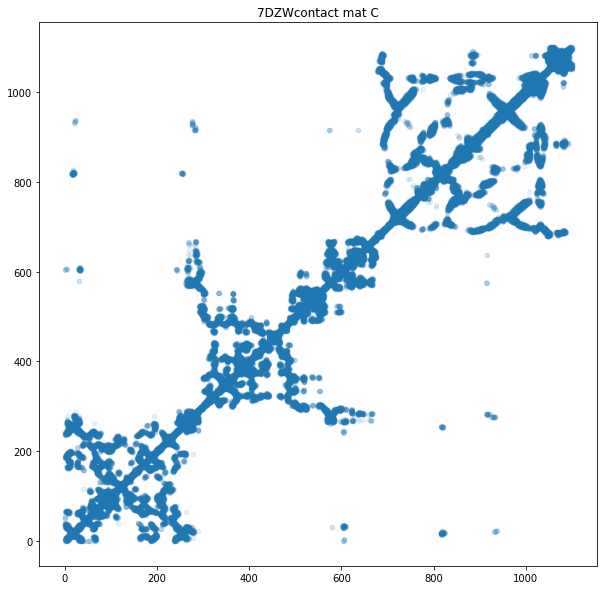

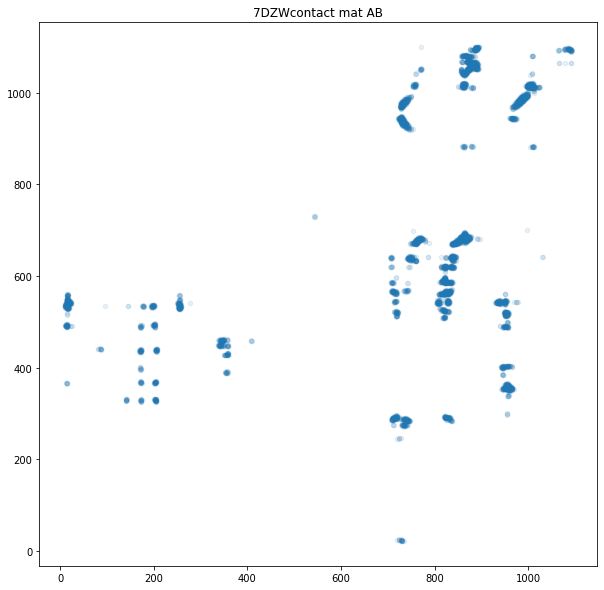

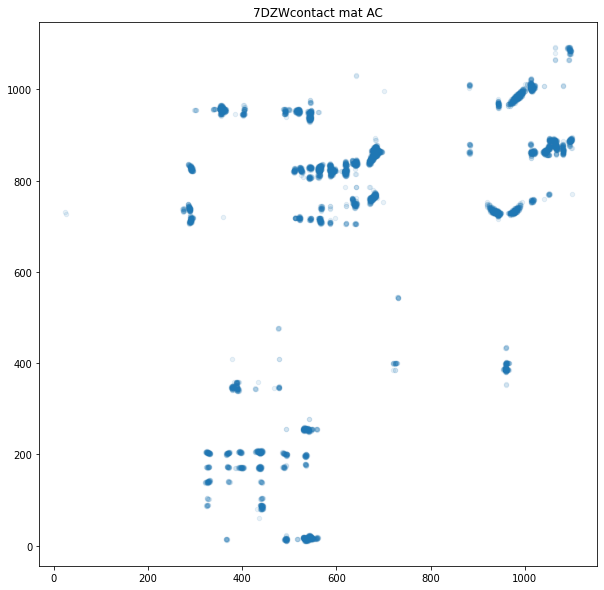

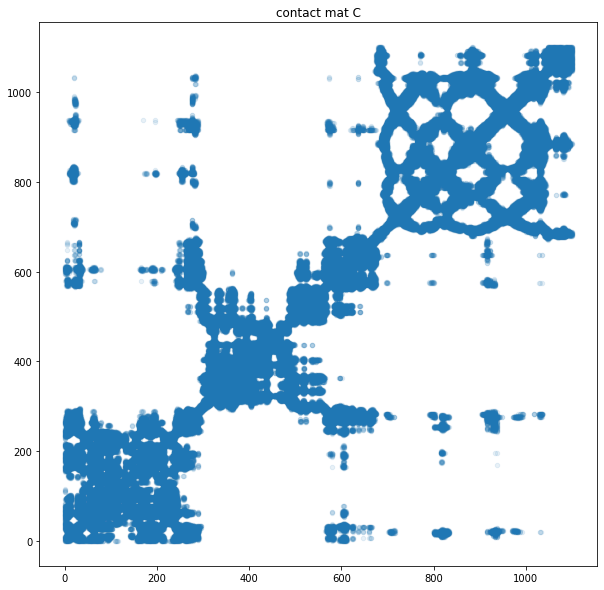

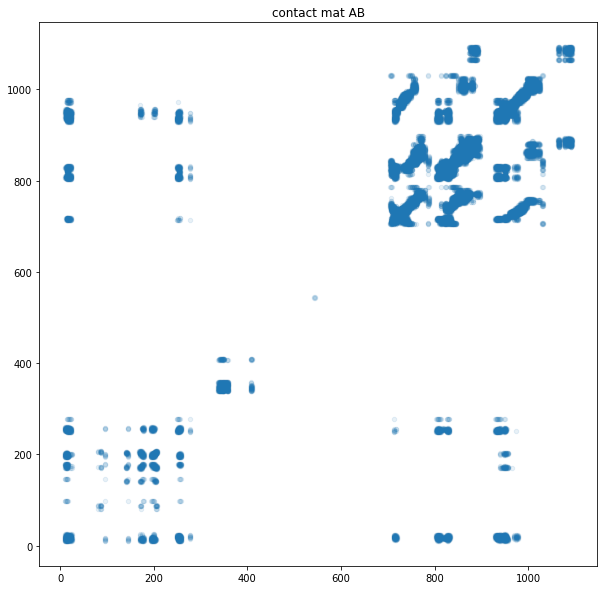

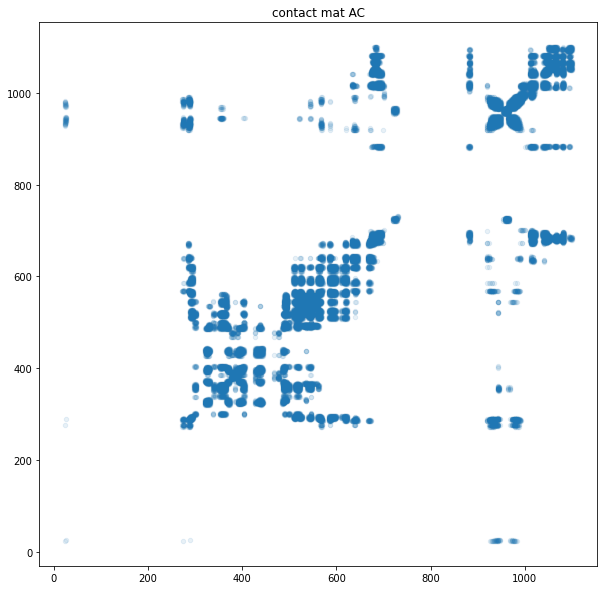

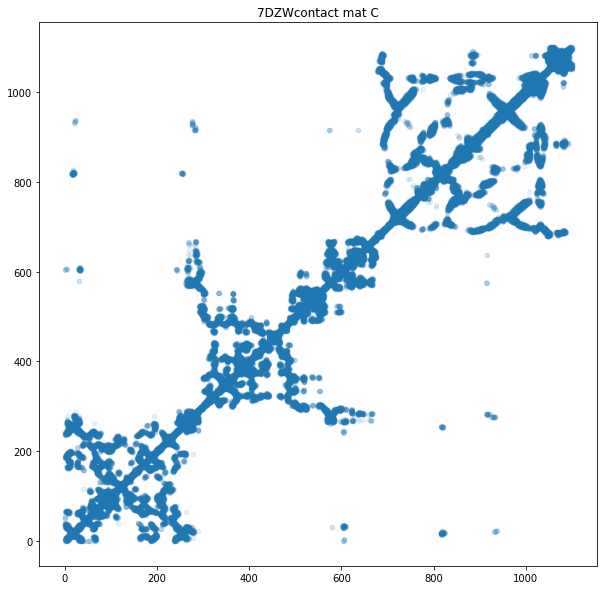

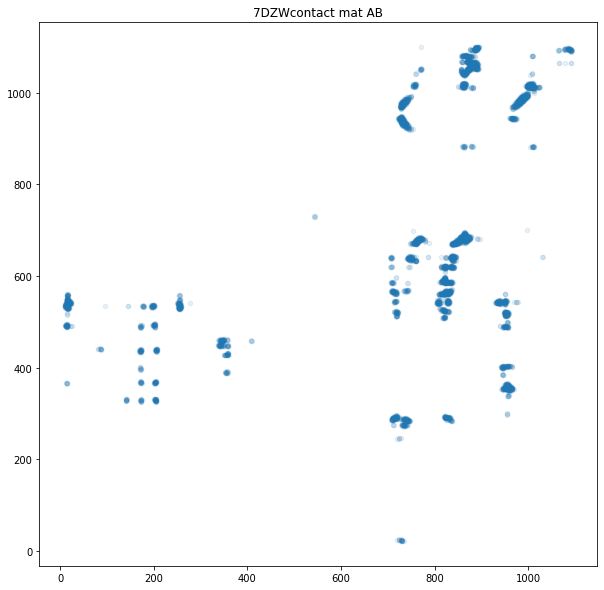

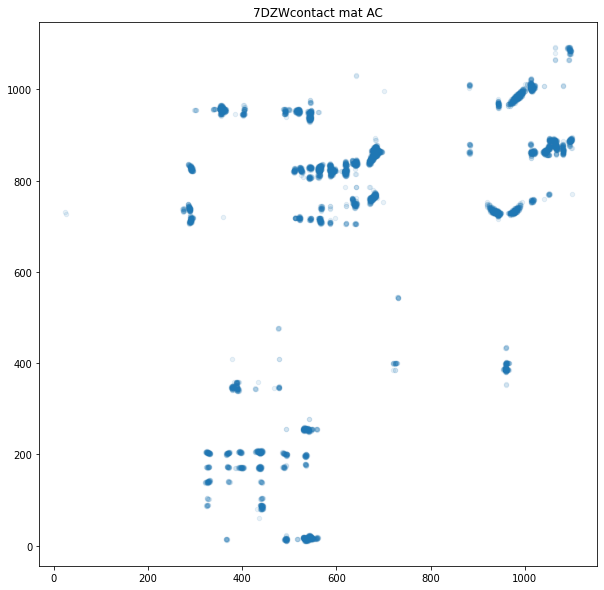

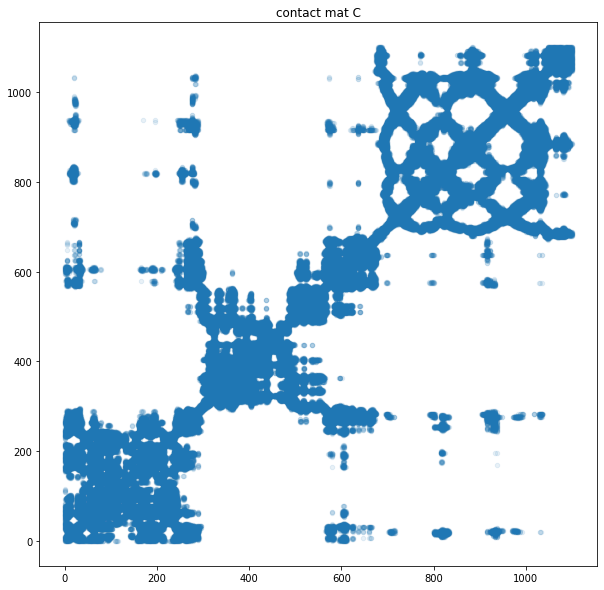

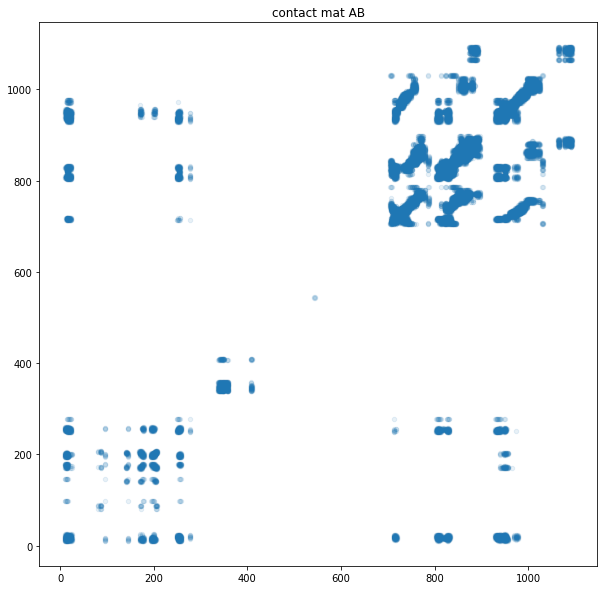

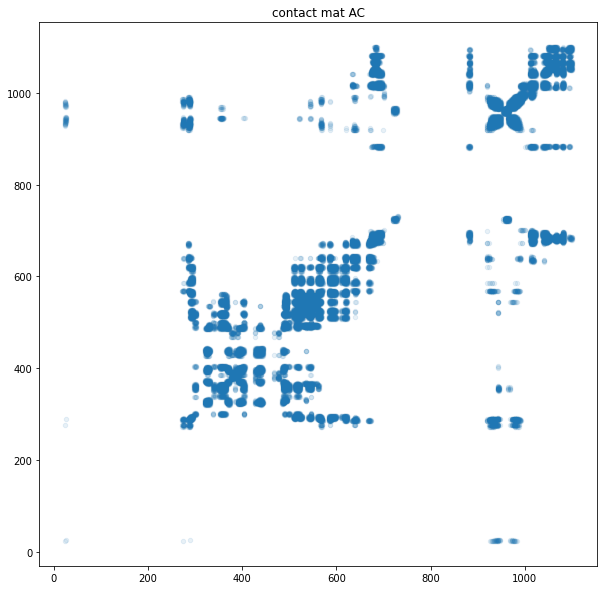

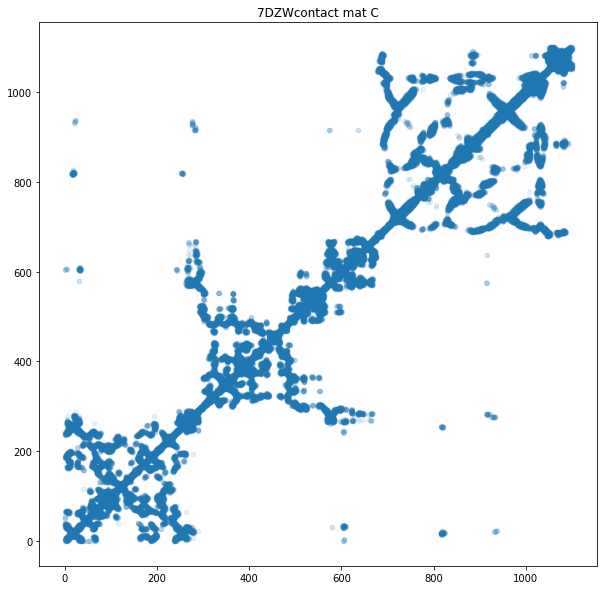

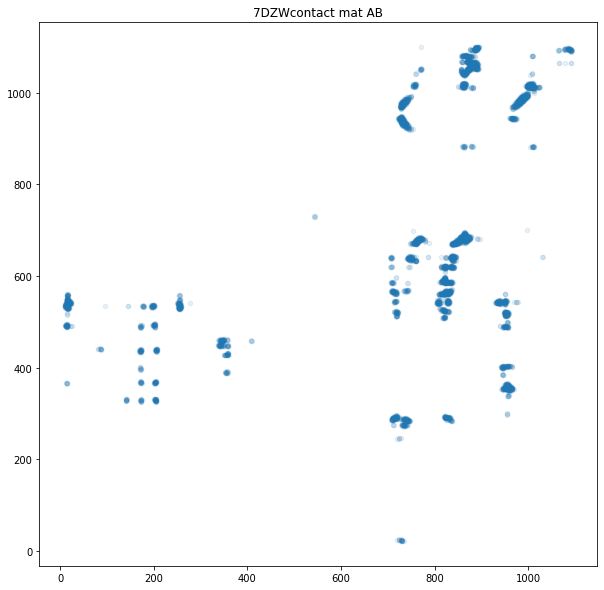

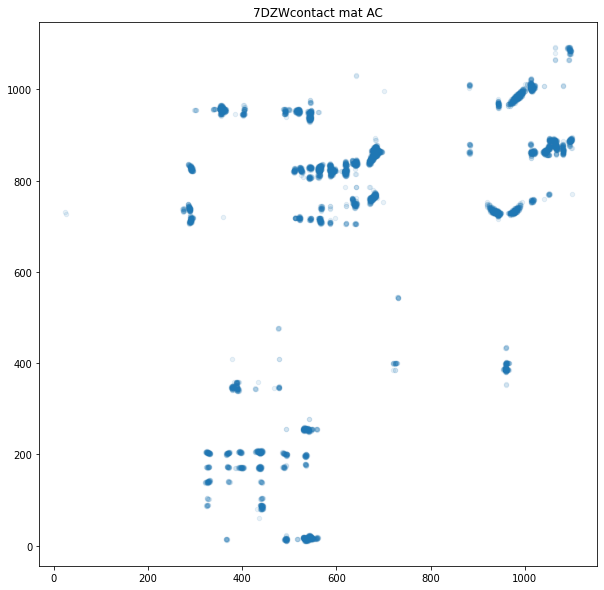

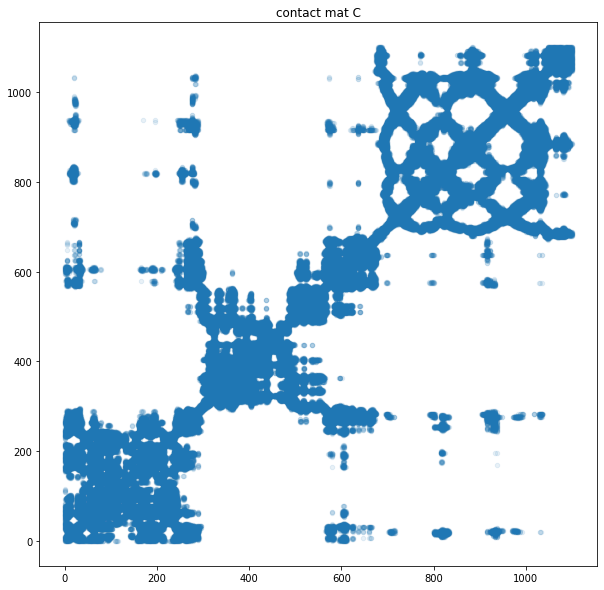

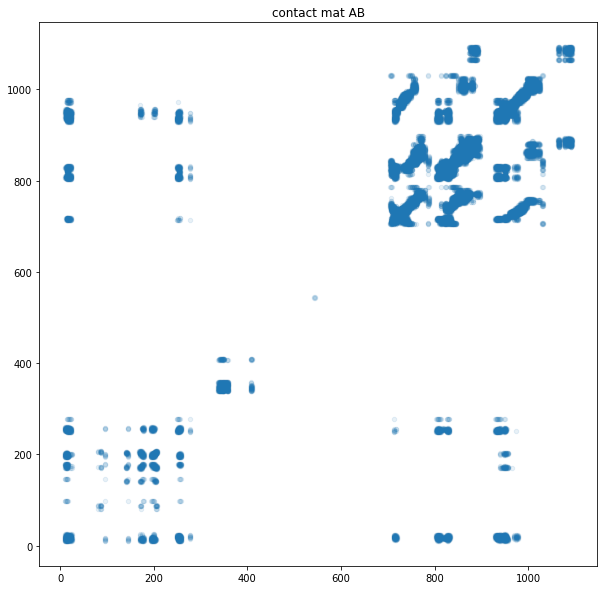

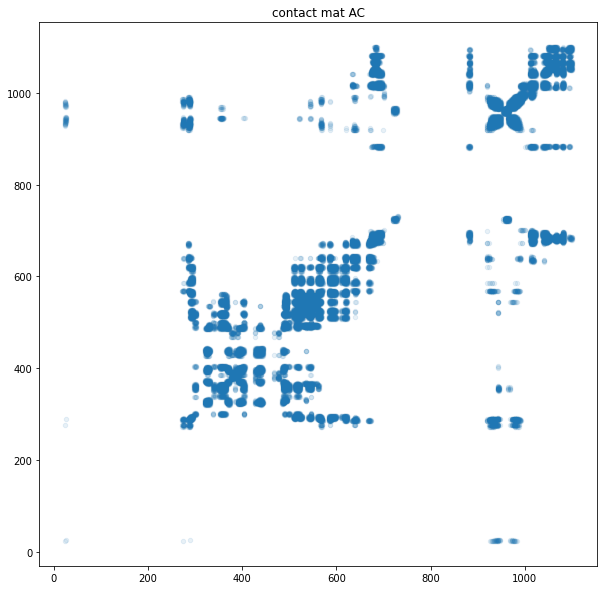

In [159]:
import copy
angstrom_cutoff = 15
show_contacts = True

if overwrite_connect == True:
    @dask.delayed( nout = 2)
    def define_contacts(mat , angstrom_cutoff = 15 ):
        subthresh = copy.deepcopy(mat)
        subthresh[ subthresh < angstrom_cutoff ] = 1 
        subthresh[ subthresh > angstrom_cutoff ] = 0 
        np.fill_diagonal(subthresh , 0)
        subthresh = subthresh[0:subthresh.shape[0]-20,0:subthresh.shape[1]-20]
        connected = np.dot(subthresh,subthresh.T)
        return subthresh,connected

    subthresh_thresh ={}
    subthresh_connected ={}

    chain_equivalencies={}
    for m in distmats:
        for chain in distmats[m]:
            if m not in subthresh_thresh:
                subthresh_thresh[m]={}
                subthresh_connected[m] ={}

                for chain in distmats[m]:
                    subthresh, connected = define_contacts(distmats[m][chain] , angstrom_cutoff  )
                    subthresh_thresh[m][chain] = subthresh
                    subthresh_connected[m][chain] = connected
            subthresh_thresh[m] = dict( zip ( subthresh_thresh[m].keys() , dask.compute( * list(subthresh_thresh[m].values() ))))
            subthresh_connected[m] = dict( zip ( subthresh_connected[m].keys() , dask.compute( * list(subthresh_connected[m].values() ))))

            if show_contacts == True:
                for chain in subthresh_thresh[m]:
                    subthresh = subthresh_thresh[m][chain]

                    plt.figure(figsize=(10,10) )
                    plt.title(m +'contact mat '+ ''.join(chain) )
                    plt.scatter( np.nonzero(subthresh)[0] ,np.nonzero(subthresh)[1]  , marker= 'o' , alpha = .1 ,  s = 20)
                    plt.show()

                for chain in subthresh_connected[m]:
                    connected = subthresh_connected[m][chain]
                    plt.figure(figsize=(10,10) )
                    plt.title('contact mat '+ ''.join(chain) )
                    plt.scatter( np.nonzero(connected)[0] ,np.nonzero(connected)[1]  , marker= 'o' , alpha = .1 ,  s = 20)
                    plt.show()

    with open(modeldir + 'contactmaps' , 'wb') as connectout:
        connectout.write(pickle.dumps((subthresh_thresh , subthresh_connected)))
else:
    with open(modeldir + 'contactmaps' , 'rb') as connectout:
        subthresh_thresh , subthresh_connected = pickle.loads(connectout.read())

In [160]:
def retcodon_mats(annotation , AAmat , plt = False):
    positions = set([])
    AAmat = scipy.sparse.csc_matrix(AAmat)
    print('converted')
    
    slices = []
    for i,r in annotation.iterrows():
        if (r.qstart-1, r.qend-1) not in slices:        
            slices.append((r.qstart-1, r.qend-1))
    count = 0
    for start,end in slices:
        codonmat = np.zeros(( AAmat.shape[0] , int((end - start + 10 ) /3) ) )
        for j,codon in enumerate(range(start-1, end-1 , 3 )):
            cols = np.sum( AAmat[:, codon:codon+2] , axis = 1 )
            codonmat[:,count] = cols.ravel()
            count+=1
            if count%500 == 0 and count >0:
                print(count/codonmat.shape[1])
        yield codonmat 
        
        if plt == True:
            print(np.sum(codonmat))
            plt.figure(figsize=(20,20))
            plt.spy(codonmat, markersize= .5)
            plt.show()

In [37]:
from sklearn.manifold import MDS , LocallyLinearEmbedding ,SpectralEmbedding
#from sklearn.preprocessing import StandardScaler
#from sklearn.cluster import MiniBatchKMeans, DBSCAN ,SpectralClustering ,OPTICS , AgglomerativeClustering

from dask_ml.cluster import SpectralClustering

import sklearn
import joblib
#loop her for blurs 


In [38]:
def return_clustering(codonmat, calc_isomap = True , scale = False , dbscan = False , xi = 0.035 , samples = 5 , jaccard = True , reductionfactor= .75 ,clustiter =0):
        if scale == True:
            scaler = sklearn.preprocessing.RobustScaler( )
            codonmat = scaler.fit_transform(codonmat.T).T
        if calc_isomap == True:
            print('dimensionality reduction')
            isomap = LocallyLinearEmbedding(n_neighbors=min(25,int(codonmat.shape[1]/3)),n_components= int(codonmat.shape[1]/2) ,n_jobs = -1)
            with joblib.parallel_backend('dask'):
                isomap.fit_transform(codonmat.T).T
        print(clustiter)
        print('kmeans')
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            apb = MiniBatchKMeans(n_clusters= min( 100 , int(codonmat.shape[1]/3) )) 
            cluster_labels_codon = apb.fit_predict(codonmat.T ) 
            cluster_labels_codon[ np.sum(codonmat , axis = 0 ).flat == 0 ] = -1
        return cluster_labels_codon

def subcluster( mat , cluster_thresh=15 , indices = None  ,  iter_thresh = 2 , clusterlevel = 'head' , clustiter =0, calc_isomap = False , scale = False , xi = .035 , samples = 5 , verbose = True , jaccard = False  ):
    #break a large cluster into smaller subclusters until cluster size is below thresh
    if verbose == True:
        print('clustering' , clusterlevel)
    cluster_labels = return_clustering(mat, calc_isomap=calc_isomap  , scale=scale  , dbscan=dbscan  ,xi = xi , samples = samples , jaccard = jaccard ,clustiter =clustiter +1)
    
    if verbose == True:
        print('DONE clustering ', clusterlevel)
    
    indices = np.arange(mat.shape[1])
    l,c = np.unique(cluster_labels, return_counts= True)
    
    if verbose == True:
        print('l',l)
        print('c',c)
    clustering = {  'labels': cluster_labels , 'sub':{} , 'mappings':{} , 'mappings_rev':{} , 'newindex':{} }
    #if we're over the max recursion
    kmeans = False
    if clustiter < iter_thresh and len(l) > 1:
        for i,label in enumerate(list(l)):
            for colcount,index in enumerate(list(indices[cluster_labels == label])):
                clustering['mappings_rev'][index] = label
                clustering['newindex'][index]= colcount
            
            clustering['mappings'][label] = indices[cluster_labels == label]
            if c[i] > cluster_thresh:
                if verbose == True:
                    print( 'reclustring',label , c[i] )
                #isomap within clusters                
                #don't split up clusters formed from columns with no events
                if np.amax(mat[:,cluster_labels==label])> 0 :
                    clustering['sub'][label] = subcluster( mat[:,cluster_labels==label] , cluster_thresh =cluster_thresh ,indices= clustering['mappings'][label] , iter_thresh = iter_thresh , clusterlevel= str(label)+'_'+str(clustiter), samples = samples,  clustiter = clustiter + 1 , calc_isomap = True , jaccard = True ,  xi= xi , scale = scale  )
                    samples = max( 2 , samples-1 )
    return clustering

In [39]:
def return_sub(indict, level= 0 ):
    l,c = np.unique(indict['labels'] , return_counts= True)
    print(level)
    print(l)
    for clust in list(l):
        if clust != -1:
            if 'sub' not in indict or clust not in indict['sub']:
                    yield (indict['mappings'][clust],level)
            else:
                print('deeper')
                print(level)
                
                return_sub( indict['sub'][clust], level = level + 1 )
            

def divide_clusters( subclustering_dict , cols ):
    #only go down one level for now
    cluster_dict={}
    count =0
    total_labels = np.ones((cols,))*-1
    labelset = set([])
    for mapping in return_sub(subclustering_dict):
        #print(mapping, count)
        total_labels[mapping[0]] = count
        count += 1
    return total_labels
    #setup sublcluster dictionary


In [40]:
overwrite_clustering =False
if overwrite_clustering == True:
    print('recursive clustering')

    np.random.seed(0)
    for pklmat in blurmats:
        with open(pklmat, 'rb') as matin:
            blurfactor, bluriter, mat = pickle.loads(matin.read())
        print(blurfactor, bluriter)
        mat= np.hstack([ m for m in retcodon_mats(annotation , mat , plt = False)] )
        mat = mat.T
        mat[mat<.001] = .001
        mat[np.isnan(mat)] = 0
        mat[mat == np.inf ] = 0
        mat[mat > 10**5 ] = 10**5
        #print(mat.shape)
        #mat = dask.array.from_array(mat.T )
        #mat = mat.map_blocks( )
        #mat = mat.rechunk({1: mat.shape[1]})
        with dask.config.set(**{'array.slicing.split_large_chunks': True}):
            clusterdict = subcluster( mat.T , calc_isomap= False  )
        with open( pklmat + 'clusterdict.pkl' , 'wb') as clusterout:
            clusterout.write( pickle.dumps(( (blurfactor, bluriter, clusterdict )) ) )
    print('done')

In [41]:
#@dask.delayed()
def check_point(contactsx , contactsy, ptx,pty, radius = 10 , verbose = False):
    #find non zero contact pts
    for center_x, center_y, in zip(contactsx,contactsy):
        if (ptx - center_x)**2 + (pty - center_y)**2 < radius**2:
            if verbose == True:
                print(ptx,pty,center_x, center_y)
                print('left', (ptx - center_x)**2 + (pty - center_y)**2 )
                print( 'right', radius**2 )
            return True
    return False


In [42]:
#calculate clustering using recursive optics and isomap
verbose = True
show_intra_clust_dist = False
show_hits = True 
show_mat = False

import itertools
from scipy.stats import gumbel_l
#connected = np.dot(subthresh,subthresh)
#connnectedx , connectedy  = (np.nonzero(connected)[0] ,np.nonzero(connected)[1])
#globalmat_blur_thresh = copy.deepcopy(globalmat_blur)
#globalmat_blur_thresh[ globalmat_blur_thresh < 20 ] = 0

#for blur iter in blur
#count the number of green / orange / red
maxiter = 20
blurs = []

increment = 100
blurs = 0
blurvec =[0]
lastreds = 100
totalreds = [0]
totalgreens = [0]
totaloranges = [0]
shuffle_iter = 1000

hits ={}
#find within cluster eval for a pair 
import random

In [115]:
def struct_hits( cluster_labels , threshat, connectmat , struct , chain , l , c , verbose = False , radius = 5 , randsamples = 5):
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for k in range(len(l))   ]
    
    subthresh = threshmat
    
    
    
    plt.figure(figsize=(20,20) )
    plt.scatter( np.nonzero(subthresh)[0] ,np.nonzero(subthresh)[1]  , marker= 'o' , alpha = .025,  s = 50)

    for i,label in enumerate(list(l.flat)):
        if c[i]< 15 and c[i]>1:
            print( i)
            zeroed = np.where(cluster_labels == label )[0]
            
            if len(list(zeroed))>2:
                #all combos
                nz_pts = np.array([ [ ptx, pty ] for ptx,pty in itertools.combinations(list(zeroed) , 2 ) ])
                plt.scatter( nz_pts[:,0] , nz_pts[:,1] , c= color[i] , marker= 'X', s=100)
                plt.scatter( nz_pts[:,1], nz_pts[:,0] , c= color[i] , marker= 'X' , s=100)
    plt.show()
    plt.figure(figsize=(20,20) )
    #red and green plt

    reds =[]
    oranges=[]
    greens =[]

    for i,label in enumerate(list(l.flat)):
        if c[i]< 15 and c[i]>1 :
            print(i)
            mask = copy.deepcopy(subthresh)
            zeroed = np.where(cluster_labels == label )[0]
            if len(list(zeroed))>2:
                
                #change here for offset
                nz_pts = [ ( ptx, pty ) for ptx,pty in itertools.combinations(list(zeroed) , 2 ) ]
                randopts = list( zip( list(np.random.uniform(0,subthresh.shape[1], randsamples*len(nz_pts))) , list(np.random.uniform(0,subthresh.shape[1], randsamples*len(nz_pts))) ) )
                green = [ check_point(list(np.nonzero(subthresh)[0]) , list(np.nonzero(subthresh)[1]), ptx , pty,radius = radius )  for ptx,pty in  nz_pts ]
                rando_green = [ check_point(list(np.nonzero(subthresh)[0]) , list(np.nonzero(subthresh)[1]), ptx , pty,radius = radius )  for ptx,pty in  randopts ]
                #green = np.array( dask.compute(*green) )
                green = np.array(green)
                if len(green)>0:
                    if connected is not None:
                        orange = [ check_point(list(np.nonzero(connectmat)[0]) , list(np.nonzero(connectmat)[1]), ptx , pty,radius = radius )  for ptx,pty in nz_pts ]
                        rando_orange = [ check_point(list(np.nonzero(connectmat)[0]) , list(np.nonzero(connectmat)[1]), ptx , pty,radius = radius )  for ptx,pty in nz_pts ]

                        #orange = np.array(dask.compute(*orange) )
                        both = list(np.logical_and( green , orange ))
                        orange = np.array(orange)
                        orange[ both ] = False
                        
                        rando_both = list(np.logical_and( rando_green , rando_orange ))
                        rando_orange = np.array(rando_orange)
                        rando_orange[ rando_both ] = False
                        
                    red = copy.deepcopy(green)
                    if len(red)>0:
                        red = ~red
                        if connected is not None:
                            red[orange == True] = False
                            
                    rando_red = copy.deepcopy(rando_green)
                    if len(red)>0:
                        rando_red = ~rando_red
                        if connected is not None:
                            rando_red[rando_orange == True] = False
                    
                    
                    ones = np.ones((len(nz_pts),))
                    if len(red)==0:
                        reds.append(0)
                    else:
                        reds.append(np.sum(ones[red]))
                    if connected is not None:
                        oranges.append(np.sum(ones[orange]))
                    else:
                        oranges.append(0)
                    
                    greens.append(np.sum(ones[green]))
                    
                    
                    
                    ones = np.ones((len(nz_pts),))
                    if len(red)==0:
                        reds.append(0)
                    else:
                        reds.append(np.sum(ones[red]))
                    if connected is not None:
                        oranges.append(np.sum(ones[orange]))
                    else:
                        oranges.append(0)
                    
                    greens.append(np.sum(ones[green]))
                    
                    
                    
                    #pts = np.array( [[ptx,pty] for ptx,pty in  itertools.combinations(list(zeroed) ,2) ] )
                    nz_pts = np.array(nz_pts)
                    plt.scatter( nz_pts[green,0] ,nz_pts[green,1], c= 'green' , marker= 'X', s=100)
                    plt.scatter( nz_pts[green,1] ,nz_pts[green,0], c= 'green' , marker= 'X', s=100)

                    plt.scatter( nz_pts[red,0] ,nz_pts[red,1] , c= 'red' , marker= 'X' , s=100)
                    plt.scatter( nz_pts[red,1] ,nz_pts[red,0] , c= 'red' , marker= 'X' , s=100)
                    
                    if connected is not None:
                        plt.scatter( nz_pts[orange,1] ,nz_pts[orange,0], c= 'orange' , marker= 'X', s=100)
                        plt.scatter( nz_pts[orange,0] ,nz_pts[orange,1], c= 'orange' , marker= 'X', s=100)      
    
    plt.scatter( np.nonzero(subthresh)[0] ,np.nonzero(subthresh)[1]  , marker= 'o' , alpha = .01,  s = 50)
    plt.show()
    return green, oranges, reds


['/scratch/dmoi/datasets/covid_data/msa_0730/msa_0730.fasta_0.2_30blursave.pklclusterdict.pkl', '/scratch/dmoi/datasets/covid_data/msa_0730/msa_0730.fasta_0.2_10blursave.pklclusterdict.pkl', '/scratch/dmoi/datasets/covid_data/msa_0730/msa_0730.fasta_0.2_20blursave.pklclusterdict.pkl']
converted
0.44483985765124556
0.8896797153024911
(109535, 1124)
0.2 30
0
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 55 56 57 58 59 60 61 62 63 64 66 67 68 70 71 72 73 74 76
 77 78 79 80 82 83 84 85 86 90 91 92 93 94 95 96 97 98 99]
deeper
0
deeper
0
deeper
0
deeper
0
deeper
0
deeper
0
deeper
0
deeper
0
deeper
0
deeper
0
deeper
0
deeper
0
deeper
0
deeper
0
labels [-1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34.
 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52.
 53. 54. 55

TypeError: list indices must be integers or slices, not tuple

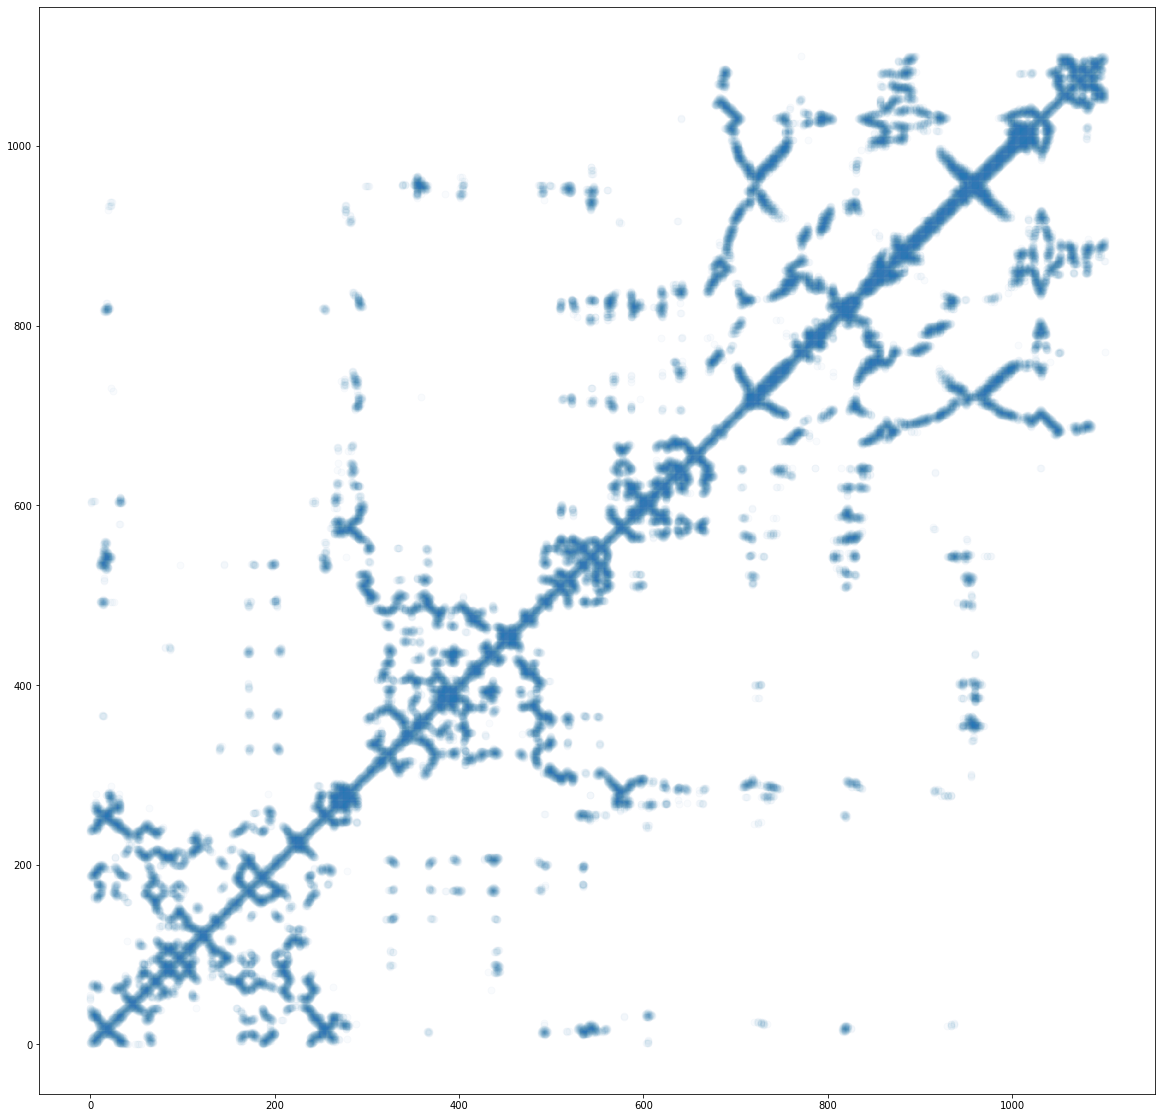

In [99]:
clustering_results = glob.glob( alnfile + '*clusterdict.pkl')
print(clustering_results)

with open(blurmats[0], 'rb') as matin:
    blurfactor, bluriter, mat = pickle.loads(matin.read())
mat= np.hstack([ m for m in retcodon_mats(annotation , mat , plt = False)] )
print(mat.shape)



totalgreens = []
totaloranges = []
totalreds = []
bluriters = []
labeldict = {}


for res in clustering_results:
    with open( res , 'rb') as resin:
        blurfactor, bluriter, clusterdict = pickle.loads(resin.read())
        print(blurfactor, bluriter)
        cluster_labels = divide_clusters( clusterdict  , mat.shape[1] )
        l,c = np.unique(cluster_labels, return_counts= True)
        print('labels' , l )
        print('counts' , c )
        
        for i,chain in enumerate(subthresh_thresh['7DZW']):
            if i ==0:
                threshmat = subthresh_thresh['7DZW'][chain]
                connectmat = subthresh_connected['7DZW'][chain]
            else:
                threshmat += subthresh_thresh['7DZW'][chain]
                connectmat += subthresh_connected['7DZW'][chain]
        green, oranges, reds = struct_hits( cluster_labels , threshmat , connectmat , struct = '7DZW' , chain=chain , l=l , c=c , verbose = False , radius = 10)
        bluriters.append(bluriter)
        print(green, oranges, reds)
        totalgreens.append( np.sum(green))
        totaloranges.append( np.sum(oranges))
        totalreds.append(np.sum(reds))

In [ ]:

green2red = np.divide( np.array(totalgreens) , np.array(totalreds)+np.array(totalgreens ) )


index = np.argsort( bluriters)
print(index)
bluriters = np.array(bluriters)
bluriters = bluriters[index]
totalgreens = np.array(totalgreens)[index]
totalreds = np.array(totalreds)[index]
totaloranges = np.array(totaloranges)[index]

fig, ax1 = plt.subplots( figsize=(10,10))

ax1.set_xlabel('blurs')
ax1.set_ylabel('counts', color='black')
ax1.plot( bluriters,  totalgreens , color='green' , label= 'greens')
ax1.plot(bluriters,  totalreds , color='red', label = 'reds')
ax1.plot(bluriters, totaloranges , color='orange', label = 'oranges')

positives = np.array(totaloranges) + np.array(totalgreens)
ax1.plot(bluriters, positives , color='orange' , linestyle='dashed' , label = "positives (g+o) ")

positives2red = np.divide( positives  ,positives + np.array(totalreds)  )

ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('green to red ratio', color='black')  # we already handled the x-label with ax1
ax2.set_ylim( (0,1.25))
ax2.plot( bluriters, green2red , linestyle='dashed'  , color='black' , label = 'green/green+red')
ax2.plot( bluriters , positives2red , linestyle='dotted'  , color='black' , label = 'positives/positives+red')

ax2.tick_params(axis='y', labelcolor='black')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.legend(loc='center right')
ax2.legend(loc='upper right')

plt.show()



In [101]:
#now w keras embedding...


from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model
import pickle



alnfile = '/scratch/dmoi/datasets/covid_data/msa_0730/msa_0730.fasta'
treefile = '/scratch/dmoi/datasets/covid_data/msa_0730/global.tree'

with open( alnfile + '_blurmat.pkl' , 'rb' ) as matout:
    sampling,index ,blurmat = pickle.loads(matout.read() ) 
#index is mapping from aln col 2 int
rev_index = dict( zip( index.values(), index.keys() ) )

print(len(rev_index))
modelh5 ='/scratch/dmoi/datasets/covid_data/msa_0730/msa_0730.fastaembedding_newfile_TF.h5'
model = load_model(modelh5)
print(model)
weights = model.get_weights()[0]
print(weights.shape)

7814
(7814, 10)


In [116]:

print(annotation)

def retcodon_mats_keras(annotation , weights, index):
    positions = set([])
    print('converted')
    
    slices = []
    for i,r in annotation.iterrows():
        if (r.qstart-1, r.qend-1) not in slices:        
            slices.append((r.qstart-1, r.qend-1))
        
    count = 0
    for start,end in slices:
        codonmat = np.zeros(( int( (end - start )/3) , weights.shape[1] ) )
        for j,codon in enumerate(range(start-1, end-1 , 3 )):
            
            if codon in index:
                if j< 10:
                    print(codon)
                    print(weights[index[codon],:])
                    
                codonmat[count,:] = weights[index[codon],:]
                count+=1

        yield codonmat
        
print( next(retcodon_mats_keras(annotation , weights, index)).shape )


  qseqid                                             sseqid   qlen  slen  \
0    EPI  /scratch/dmoi/datasets/covid_data/structs/7DZW...  29903  1121   
1    EPI  /scratch/dmoi/datasets/covid_data/structs/7DZW...  29903  1121   
2    EPI  /scratch/dmoi/datasets/covid_data/structs/7DZW...  29903  1121   

   qstart   qend  qframe  evalue struct chain  
0   21641  25003       2     0.0   7DZW     C  
1   21641  25003       2     0.0   7DZW     B  
2   21641  25003       2     0.0   7DZW     A  
converted
21639
[ 0.00156592  0.00962603 -0.06851161 -0.0238788   0.04745164 -0.03628366
  0.03837384 -0.02509322  0.01292176  0.03929658]
21642
[-0.02571294  0.02129262  0.0011281  -0.00179508  0.0124267   0.02532072
 -0.00584783 -0.00221589  0.02546914 -0.0229409 ]
21645
[ 0.13137719 -0.03446571 -0.21428154 -0.07485398  0.21234475  0.05074682
 -0.22409502 -0.25530377  0.12976445  0.34620816]
21648
[ 0.22562434  0.31749186 -0.31715018 -0.22569786 -0.05108941  0.42110276
  0.2854214   0.1375341  -0

In [117]:

from sklearn.cluster import OPTICS, cluster_optics_dbscan  , AgglomerativeClustering
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

AATF = next(retcodon_mats_keras(annotation , weights, index))

clust = OPTICS(min_samples=5, xi=.0005, min_cluster_size=2 )
clust.fit(AATF)
optics_l = clust.labels_
l,c = np.unique(clust.labels_, return_counts= True)
print('labels' , l )
print('counts' , c )

clust = AgglomerativeClustering(n_clusters=100  ,  affinity='euclidean')
clust.fit( AATF)
aglo_l = clust.labels_

l,c = np.unique(clust.labels_, return_counts= True)
print('labels' , l )
print('counts' , c )


converted
21639
[ 0.00156592  0.00962603 -0.06851161 -0.0238788   0.04745164 -0.03628366
  0.03837384 -0.02509322  0.01292176  0.03929658]
21642
[-0.02571294  0.02129262  0.0011281  -0.00179508  0.0124267   0.02532072
 -0.00584783 -0.00221589  0.02546914 -0.0229409 ]
21645
[ 0.13137719 -0.03446571 -0.21428154 -0.07485398  0.21234475  0.05074682
 -0.22409502 -0.25530377  0.12976445  0.34620816]
21648
[ 0.22562434  0.31749186 -0.31715018 -0.22569786 -0.05108941  0.42110276
  0.2854214   0.1375341  -0.3047463   0.1827341 ]
21657
[-0.04330014 -0.03630397 -0.0277166   0.03592569 -0.10437512  0.02256115
  0.05507647  0.08526131 -0.00120186  0.01610986]
21660
[ 0.04579619  0.0786566  -0.31619078  0.34193173  0.17418748 -0.19203669
 -0.07039323 -0.07725215  0.02484771 -0.17708218]
21663
[-0.14477324 -0.09129016 -0.07146432 -0.1557677  -0.14402474 -0.09836098
  0.08413372  0.17477997 -0.03828133  0.02414973]
labels [-1  0  1  2  3  4  5  6  7  8]
counts [484 581   4   5  10   8   7   4   7  10]

/scratch/dmoi/miniconda/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_optics.py:807: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [112]:
X = weights

In [118]:
print(optics_l.shape)
print(optics_l[1000:])

(1120,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


{'C': array([[ 28.,  19.,  19., ...,   0.,   0.,   0.],
       [ 19.,  34.,  31., ...,   0.,   0.,   0.],
       [ 19.,  31.,  39., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ..., 127., 114., 100.],
       [  0.,   0.,   0., ..., 114., 140., 124.],
       [  0.,   0.,   0., ..., 100., 124., 149.]], dtype=float32), ('A', 'B'): array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), ('A', 'C'): array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  9.,  8.,  7.],
       [ 0.,  0.,  0., ...,  8., 10.,  9.],
       [ 0.,  0.,  0., ...,  7.,  9., 11.]], dtype=float32)}
0
C
(1101, 1101)
1
('A', 'B')
(1101, 1101)
2
('A', 'C')
(1101, 1101)
2
3
4
5
6
7
8
9


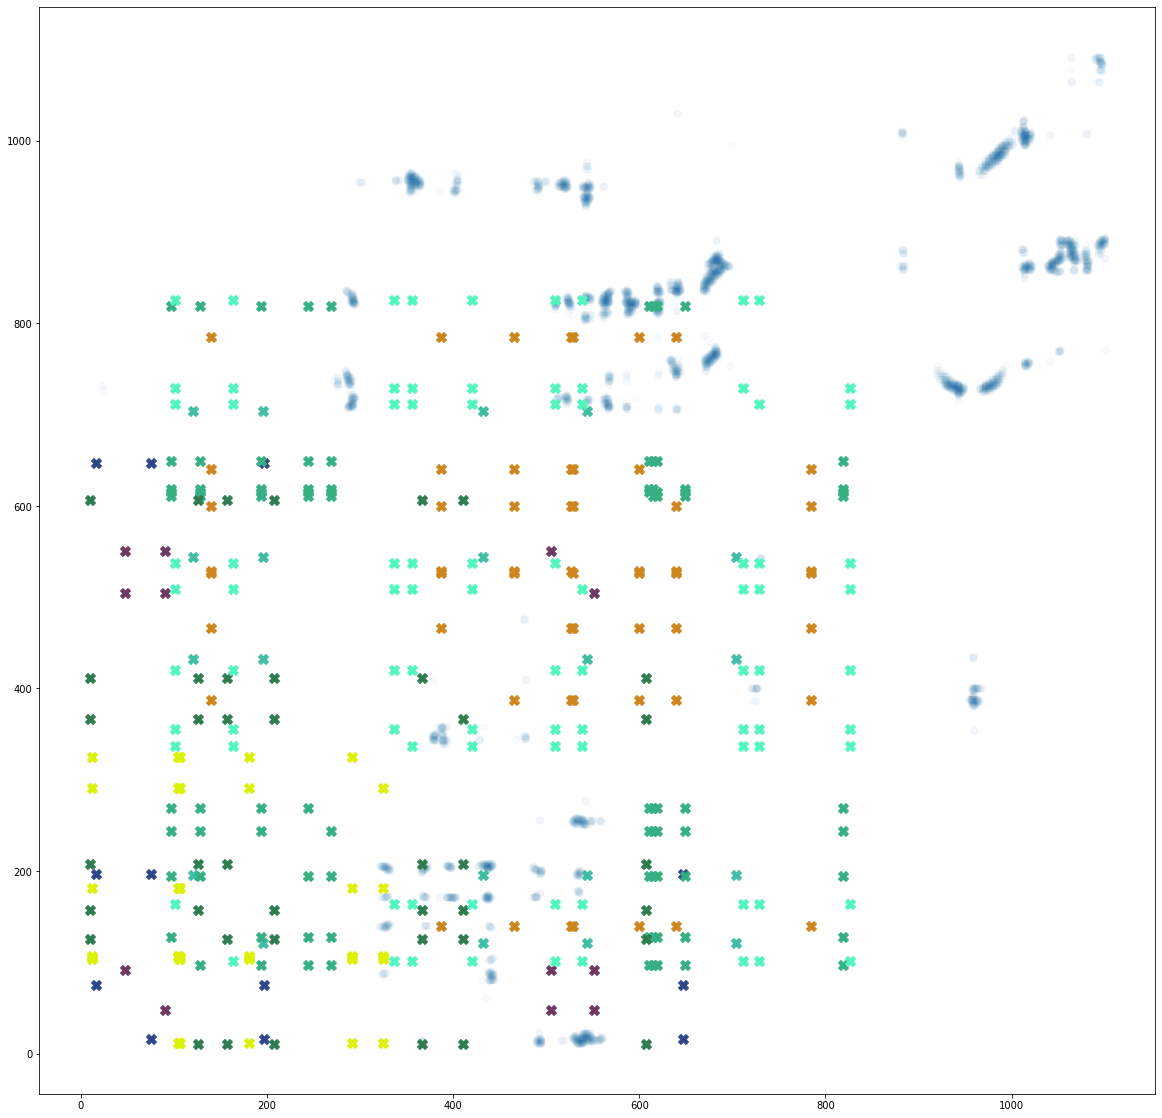

2
3
4
5
6
7
8
9


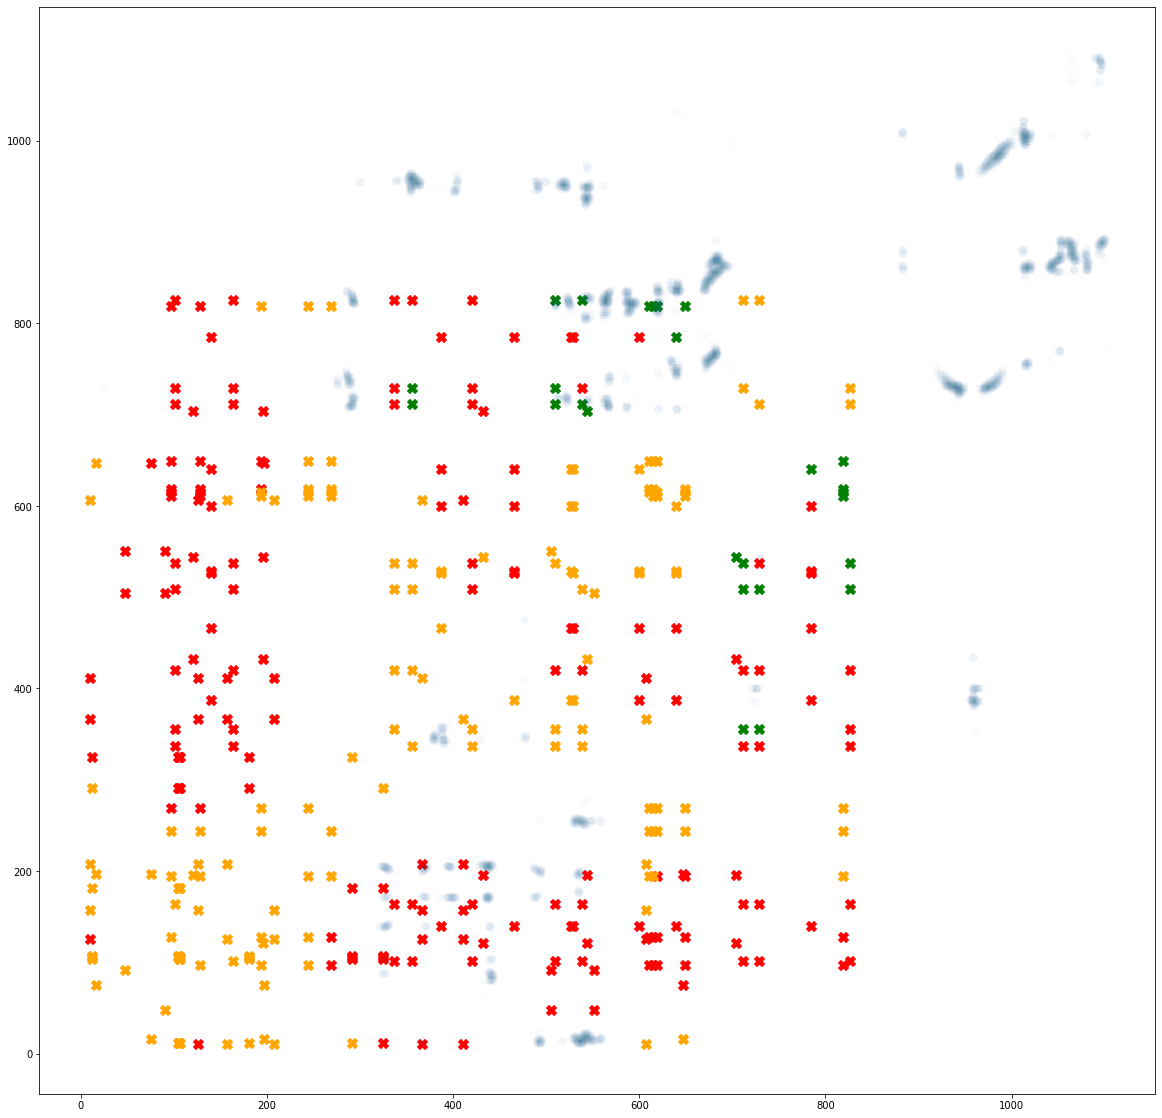

In [129]:


print(subthresh_connected['7DZW'])
total_thresh = None
total_connect = None

for i,chain in enumerate(subthresh_connected['7DZW']):
    for labels in [ optics_l]:
        l,c = np.unique(labels, return_counts= True)
        print(i)
        print(chain)
        if i == 0 :
            total_thresh = subthresh_thresh['7DZW'][chain]
            total_connect = subthresh_connected['7DZW'][chain]

            print(threshmat.shape)
            #green, oranges, reds = struct_hits( labels, threshmat , connectmat , struct = '7DZW' , chain=chain , l=l , c=c , verbose = False , radius = 10)
        else:
            total_thresh += subthresh_thresh['7DZW'][chain]
            total_connect += subthresh_connected['7DZW'][chain]
            print(threshmat.shape)

green, oranges, reds = struct_hits( labels, total_thresh , total_connect , struct = '7DZW' , chain=chain , l=l , c=c , verbose = False , radius = 10)


In [ ]:

labels_050 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=0.5)
labels_200 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=2)

space = np.arange(len(X))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
ax1.plot(space, np.full_like(space, 2., dtype=float), 'k-', alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), 'k-.', alpha=0.5)
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')

# OPTICS
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    Xk = X[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax2.set_title('Automatic Clustering\nOPTICS')

# DBSCAN at 0.5
colors = ['g', 'greenyellow', 'olive', 'r', 'b', 'c']
for klass, color in zip(range(0, 6), colors):
    Xk = X[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3, marker='.')
ax3.plot(X[labels_050 == -1, 0], X[labels_050 == -1, 1], 'k+', alpha=0.1)
ax3.set_title('Clustering at 0.5 epsilon cut\nDBSCAN')

# DBSCAN at 2.
colors = ['g.', 'm.', 'y.', 'c.']
for klass, color in zip(range(0, 4), colors):
    Xk = X[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(X[labels_200 == -1, 0], X[labels_200 == -1, 1], 'k+', alpha=0.1)
ax4.set_title('Clustering at 2.0 epsilon cut\nDBSCAN')

plt.tight_layout()
plt.show()